In [1]:
%matplotlib inline
import sys
import os

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import json
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import gridspec

COLORS = [(0.12109375, 0.46484375, 0.703125),
          (0.99609375, 0.49609375, 0.0546875),
          (0.171875, 0.625, 0.171875),
          (0.8359375, 0.15234375, 0.15625),
          (0.578125, 0.40234375, 0.73828125),
          (0.546875, 0.3359375, 0.29296875),
          (0.88671875, 0.46484375, 0.7578125),
          (0.49609375, 0.49609375, 0.49609375),
          (0.734375, 0.73828125, 0.1328125),
          (0.08984375, 0.7421875, 0.80859375)]

import calendar

# Set font sizes
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

from matplotlib import rcParams
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
CARBON_INTENSITY = {"biogas":18, "biomass":18, "geo":42, "hydro":4,
                        "imports":428, "nuclear":16, "smhydro":4, "solarpv":46, "solarth":22,
                        "thermal":469, "wind":12}
def loadCAISO(year):
    dfp = pd.read_csv(os.path.join("/content/CAISO_DailyRenewablesWatch", 'DailyRenewablesWatch_%d.csv' % year),
                      index_col=0, parse_dates=True)
    dfp.index -= pd.Timedelta('7h')

    cols = [col for col in dfp.columns if col != 'carbon']
    dfp["total"] = dfp[cols].sum(axis=1)

    dfp["carbon"] = dfp.apply(lambda row:sum(row[fuel]*CARBON_INTENSITY[fuel]
                                           for fuel in CARBON_INTENSITY)/1e3, axis=1)
    dfp["carbon_intensity"] = dfp.apply(lambda row:row["carbon"]*1e3/row["total"], axis=1)
    return dfp

df = pd.concat([loadCAISO(y) for y in [2015,2016,2017,2018]])

df.dropna(inplace=True)
df.loc[:, 'year'] = df.index.year
df.loc[:, 'month'] = df.index.month
df.loc[:, 'hour'] = df.index.hour
df.head()

,biogas,biomass,geo,hydro,imports,nuclear,smhydro,solarpv,solarth,thermal,wind,carbon,total,carbon_intensity,year,month,hour
timestamp,,,,,,,,,,,,,,,,,
2015-01-01 01:00:00+00:00,165.0,290.0,1071.0,496.0,7181.0,1085.0,195.0,0.0,0.0,12461.0,585.0,8997.993,23529.0,382.421395,2015,1,1
2015-01-01 02:00:00+00:00,165.0,278.0,1071.0,548.0,7435.0,1084.0,194.0,0.0,0.0,11571.0,360.0,8686.567,22706.0,382.567031,2015,1,2
2015-01-01 03:00:00+00:00,165.0,268.0,1071.0,604.0,6944.0,1085.0,204.0,0.0,0.0,11488.0,207.0,8435.756,22036.0,382.817027,2015,1,3
2015-01-01 04:00:00+00:00,162.0,268.0,1071.0,632.0,6705.0,1085.0,206.0,0.0,0.0,11363.0,195.0,8274.761,21687.0,381.553972,2015,1,4
2015-01-01 05:00:00+00:00,164.0,265.0,1072.0,444.0,6889.0,1084.0,194.0,0.0,0.0,11423.0,165.0,8380.501,21700.0,386.198203,2015,1,5


In [7]:
# Compute totals for dispatchable generation
cols = ["biogas", "biomass", "geo", "hydro", "imports", "nuclear", "smhydro", "thermal"]
df["total_D"] = df[cols].sum(axis=1)
df["carbon_D"] = df.apply(lambda row:sum(row[fuel]*CARBON_INTENSITY[fuel]
                                           for fuel in cols)/1e3, axis=1)
df.head()

,biogas,biomass,geo,hydro,imports,nuclear,smhydro,solarpv,solarth,thermal,wind,carbon,total,carbon_intensity,year,month,hour,total_D,carbon_D
timestamp,,,,,,,,,,,,,,,,,,,
2015-01-01 01:00:00+00:00,165.0,290.0,1071.0,496.0,7181.0,1085.0,195.0,0.0,0.0,12461.0,585.0,8997.993,23529.0,382.421395,2015,1,1,22944.0,8990.973
2015-01-01 02:00:00+00:00,165.0,278.0,1071.0,548.0,7435.0,1084.0,194.0,0.0,0.0,11571.0,360.0,8686.567,22706.0,382.567031,2015,1,2,22346.0,8682.247
2015-01-01 03:00:00+00:00,165.0,268.0,1071.0,604.0,6944.0,1085.0,204.0,0.0,0.0,11488.0,207.0,8435.756,22036.0,382.817027,2015,1,3,21829.0,8433.272
2015-01-01 04:00:00+00:00,162.0,268.0,1071.0,632.0,6705.0,1085.0,206.0,0.0,0.0,11363.0,195.0,8274.761,21687.0,381.553972,2015,1,4,21492.0,8272.421
2015-01-01 05:00:00+00:00,164.0,265.0,1072.0,444.0,6889.0,1084.0,194.0,0.0,0.0,11423.0,165.0,8380.501,21700.0,386.198203,2015,1,5,21535.0,8378.521


Text(0.5, 1.0, 'Difference in carbon dispatch accross 2015-2016')

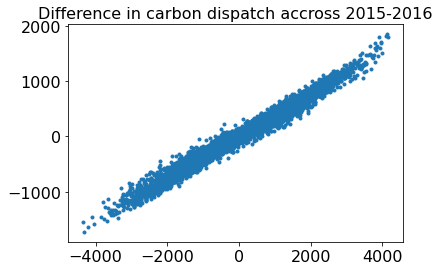

In [67]:
## Plot total dispatch vs Carbon Dispatch

f, ax = plt.subplots()
start = pd.to_datetime("2015-01-01").tz_localize('UTC')
end = pd.to_datetime("2016-01-01").tz_localize('UTC')
ax.plot(df[start:end].total_D.diff(), df[start:end].carbon_D.diff(), '.')
ax.set_title("Difference in carbon dispatch accross 2015-2016")

2015: 382.38
2016: 371.18
2017: 389.37
2018: 389.86


Text(0.5, 1.0, 'Difference in carbon dispatch accross 2015-2018')

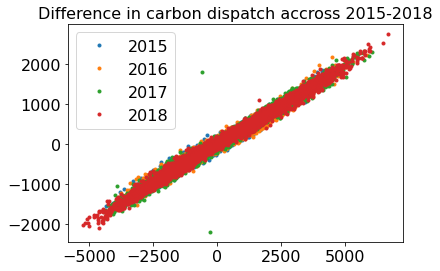

In [69]:
f, ax = plt.subplots()

for y in range(2015, 2019):
    start = pd.to_datetime("%d-01-01" %y).tz_localize('UTC')
    end = pd.to_datetime("%d-01-01" % (y+1)).tz_localize('UTC')
    df_diff = df.diff().dropna()
    df_diff.hour = df_diff.index.hour
    sel = (df_diff.index>start) & (df_diff.index<end)

    lr = LinearRegression()
    lr.fit(df_diff[sel].total_D.values.reshape(-1,1), df_diff[sel].carbon_D.values.reshape(-1,1))
    print("%d: %.2f"% (y, 1000*lr.coef_))
    
    ax.plot(df_diff[sel].total_D, df_diff[sel].carbon_D, '.', label=str(y))
ax.legend()

ax.set_title("Difference in carbon dispatch accross 2015-2018")

In [16]:
# Scenario for 2025
df25 = loadCAISO(2016)


# Initial grid mix:
tot=0
print("initial grid mix")
for col in df25.columns:
    if col not in ['carbon', 'total', 'carbon_intensity']:
        prct = 100*df25[col].sum()/df25["total"].sum()
        print("\t%s: %.2f"%(col,prct))
        tot+=prct
print("total: %.2f"%tot)

# generate scenarios
x = 2
print("max overgen power on grid (GW)")
print(min(df25.total - (1+x) * df25.solarpv)/1e3)

gencols = [col for col in df25.columns if col not in ['carbon', 'total', 'carbon_intensity']]

df_solar = df25.copy(deep=True)

# reduce thermal, but don't go negative
df_solar.thermal = df_solar.apply(
    lambda row : max(row.thermal - x*row.solarpv, 0), axis=1)

# take all the solar
df_solar.solarpv = df_solar.apply(
    lambda row : (1 + x) * row.solarpv, axis=1)

overgenP = df_solar.total - df_solar[gencols].sum(axis=1)
print("%d hours of curtailment" % (overgenP<0).sum())
curtailed = overgenP<0  # remember which hours could have been curtailed
overgen = overgenP.sum()

print("overgen energy: %.2f %% of total energy" % (-100 * overgen/df_solar.total.sum()))

print("Assuming imports can be reduced as well")
df_solar.imports = (df_solar.imports + overgenP)
df_solar.imports = df_solar.apply(
    lambda row: max(row.imports, 0), axis=1)

overgenP = df_solar.total - df_solar[gencols].sum(axis=1)
overgen = overgenP.sum()
print("overgen energy: %.2f %% of total energy" % (-100 * overgen/df_solar.total.sum()))



# Redistribute the overgeneration on hours that have space
# Find space to put the solar
thresh = 350
space = df_solar.thermal > thresh  # MW
df_solar["storage"] = 0.
gencols += ["storage"]
print("Redistributing %.2f MW on the %d timesteps that have at least %.2f MW in thermal generation" % (
        -overgen / space.sum(), space.sum(), thresh))
df_solar.loc[space, "thermal"] += overgen / space.sum()

df_solar.loc[space, "storage"] -= overgen / space.sum()

# Store the solar
df_solar.solarpv += overgenP

df25 = df_solar
df25["year"] = df25.index.year
df25["hour"] = df25.index.hour
df25["carbon"] = df25.apply(lambda row:sum(row[fuel]*CARBON_INTENSITY[fuel]
                                         for fuel in CARBON_INTENSITY)/1e3, axis=1)
df25["carbon_intensity"] = df25.apply(lambda row:row["carbon"]*1e3/row["total"], axis=1)

# 2025 grid mix
tot=0
print("2025 grid mix")
for col in df25.columns:
    if col not in ['carbon', 'total', 'carbon_intensity']:
        prct = 100*df25[col].sum()/df25["total"].sum()
        print("\t%s: %.2f"%(col,prct))
        tot+=prct
print("total: %.2f"%tot)


initial grid mix
	biogas: 0.67
	biomass: 0.84
	geo: 3.72
	hydro: 9.77
	imports: 27.93
	nuclear: 8.19
	smhydro: 1.25
	solarpv: 8.43
	solarth: 0.55
	thermal: 32.66
	wind: 5.99
total: 100.00
max overgen power on grid (GW)
0.52
2504 hours of curtailment
overgen energy: 5.45 % of total energy
Assuming imports can be reduced as well
overgen energy: 0.84 % of total energy
Redistributing 312.48 MW on the 6192 timesteps that have at least 350.00 MW in thermal generation
2025 grid mix
	biogas: 0.67
	biomass: 0.84
	geo: 3.72
	hydro: 9.77
	imports: 23.32
	nuclear: 8.19
	smhydro: 1.25
	solarpv: 24.46
	solarth: 0.55
	thermal: 20.41
	wind: 5.99
	storage: 0.84
	year: 7.66
	hour: 0.04
total: 107.70


In [18]:
# Compute totals for dispatchable generation in 2025
cols = ["biogas", "biomass", "geo", "hydro", "imports", "nuclear", "smhydro","thermal"]
df25["total_D"] = df25[cols].sum(axis=1)
df25["carbon_D"] = df25.apply(lambda row:sum(row[fuel]*CARBON_INTENSITY[fuel]
                                           for fuel in cols)/1e3, axis=1)
df25.head()

,biogas,biomass,geo,hydro,imports,nuclear,smhydro,solarpv,solarth,thermal,wind,carbon,total,carbon_intensity,storage,year,hour,total_D,carbon_D
timestamp,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00+00:00,193.0,246.0,1099.0,973.0,6470.0,2282.0,134.0,0.0,0.0,10518.521802,1141.0,7811.038725,23369.0,334.247881,312.478198,2016,1,21915.521802,7797.346725
2016-01-01 02:00:00+00:00,192.0,245.0,1099.0,1054.0,6410.0,2281.0,134.0,0.0,0.0,9761.521802,1108.0,7430.201725,22597.0,328.813636,312.478198,2016,2,21176.521802,7416.905725
2016-01-01 03:00:00+00:00,192.0,245.0,1098.0,1052.0,6262.0,2281.0,136.0,0.0,0.0,9376.521802,1051.0,7185.566725,22006.0,326.527616,312.478198,2016,3,20642.521802,7172.954725
2016-01-01 04:00:00+00:00,192.0,244.0,1099.0,1054.0,5942.0,2281.0,136.0,0.0,0.0,9351.521802,1081.0,7037.273725,21693.0,324.402974,312.478198,2016,4,20299.521802,7024.301725
2016-01-01 05:00:00+00:00,192.0,240.0,1099.0,1151.0,6119.0,2281.0,143.0,0.0,0.0,9038.521802,1150.0,6967.404725,21726.0,320.694317,312.478198,2016,5,20263.521802,6953.604725


Text(0.5, 1.0, 'Difference in carbon dispatch accross 2016-2017')

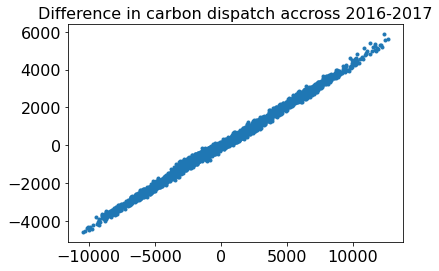

In [71]:
f, ax = plt.subplots()
start = pd.to_datetime("2016-01-01").tz_localize('UTC')
end = pd.to_datetime("2017-01-01").tz_localize('UTC')
ax.plot(df25[start:end].total_D.diff(), df25[start:end].carbon_D.diff(), '.')
ax.set_title("Difference in carbon dispatch accross 2016-2017")

In [21]:
# Sanity - these are the hours that solar will be considered the marginal fuel
print(curtailed.sum())
print((df25.thermal == 0.).sum())

2504
2504


In [24]:
mefs = dict()
df_diff = df.diff().dropna()
df_diff["hour"] = df_diff.index.hour
for y in range(2015, 2019):
    mefs[y] = []
    start = pd.to_datetime("%d-01-01" %y).tz_localize('UTC')
    end = pd.to_datetime("%d-01-01" % (y+1)).tz_localize('UTC')
    for h in range(24):
        sel = (df_diff.hour == h) & (df_diff.index>start) & (df_diff.index<end)

        lr = LinearRegression()
        lr.fit(df_diff[sel].total_D.values.reshape(-1,1), df_diff[sel].carbon_D.values.reshape(-1,1))
        mefs[y].append(1000 * lr.coef_[0][0])

# In 2025, solar is marginal when there was no more gas generation
df_diff = df25.diff().dropna()
df_diff["hour"] = df_diff.index.hour
mefs[2025] = []
for h in range(24):
    sel = (df_diff.hour == h)
    lr = LinearRegression()
    lr.fit(df_diff[sel].total_D.values.reshape(-1,1), df_diff[sel].carbon_D.values.reshape(-1,1))
    curtailed_frac = curtailed[curtailed.index.hour==h].sum()/(curtailed.index.hour==h).sum()
    mefs[2025].append(curtailed_frac * CARBON_INTENSITY["solarpv"]
                      + (1-curtailed_frac) * 1000 * lr.coef_[0][0])

mefs = pd.DataFrame(mefs)
mefs.head()

,2015,2016,2017,2018,2025
0,423.161495,383.542712,413.369531,392.972098,383.542712
1,422.129493,385.112301,438.253246,415.115851,387.571636
2,431.752408,441.467885,455.194386,450.346063,442.228799
3,434.133395,429.428850,398.329003,470.706496,427.525646
4,426.704273,368.792097,366.055941,435.403446,369.101996


In [72]:
aefs = dict()

for y in range(2015, 2019):
    start = pd.to_datetime("%d-01-01" % y).tz_localize('UTC')
    end = pd.to_datetime("%d-01-01" % (y+1)).tz_localize('UTC')
    
    grp = df.loc[start:end, ["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()
    aefs[y] = grp.loc[y, "carbon_intensity"].values
    startyr= pd.to_datetime("2016-01-01").tz_localize('UTC')
    endyr= pd.to_datetime("2017-01-01").tz_localize('UTC')
    aefs[2025] = df25.loc[startyr:endyr,
                        ["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()\
                        .loc[2016, "carbon_intensity"].values
aefs = pd.DataFrame(aefs)
aefs.head()

,2015,2025,2016,2017,2018
0,333.216252,296.175037,302.472805,276.672851,288.694661
1,328.433628,291.487639,298.082038,270.940491,284.463379
2,326.217332,288.297156,295.099199,267.056519,287.165046
3,326.405843,287.744693,294.660711,265.650291,282.664252
4,328.251778,288.955857,295.856300,267.030191,283.653282


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


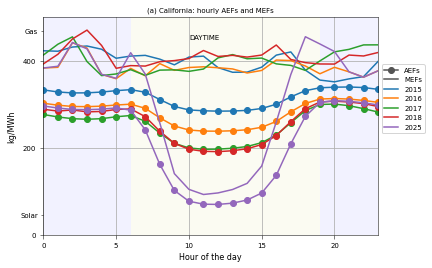

In [88]:
f, ax = plt.subplots()

ax.axvspan(0, 6, facecolor='b', alpha=0.05)
ax.axvspan(19, 23, facecolor='b', alpha=0.05)
ax.axvspan(6, 19, facecolor='y', alpha=0.05)
ax.text(10, 450, "DAYTIME")

ax.plot([], [], label="AEFs", color=(.33,.33,.33), marker='o')
ax.plot([], [], label="MEFs", color=(.33,.33,.33))

for i, y in enumerate(range(2015, 2019)):
    ax.plot(mefs[y], label=str(y), color=COLORS[i])
    ax.plot(aefs[y], label="__nolegend__", marker='o', color=COLORS[i])
i += 1
ax.plot(mefs[2025], label=str(2025), color=COLORS[i])
ax.plot(aefs[2025], label="__nolegend__", marker='o', color=COLORS[i])
  

ax.grid(True)
ax.legend(loc=2, bbox_to_anchor=(1.0, 0.8))
ax.set_xlim([0,23])
ax.set_ylim([0,500])
ax.set_xlabel('Hour of the day')
ax.set_title('(a) California: hourly AEFs and MEFs');
ax.set_ylabel('kg/MWh');
ax.set_yticks([0, 200, 400])
ax.set_yticks([CARBON_INTENSITY["solarpv"], CARBON_INTENSITY["thermal"]], minor=True)
ax.set_yticklabels(["Solar", "Gas"], minor=True)
# plt.savefig('figures/fig1a.pdf', bbox_inches='tight')
# plt.savefig('figures/fig1a.png', bbox_inches='tight')

# Save data for later use
mefs.to_csv('figures/CA_mefs.csv')
aefs.to_csv('figures/CA_aefs.csv')

# Case study using these AEFs and MEFs

In [89]:
# Split into different years
df["MEF"] = 0.
df25["MEF"] = 0.
df16 = df.loc[pd.to_datetime("2016-01-01").tz_localize('UTC'):pd.to_datetime("2017-01-01").tz_localize('UTC'),:].copy(deep=True)
df18 = df.loc[pd.to_datetime("2018-01-01").tz_localize('UTC'):pd.to_datetime("2019-12-01").tz_localize('UTC'),:].copy(deep=True)

for h in range(24):
    df16.loc[df16.hour==h, "MEF"] = mefs.loc[h, 2016]
    df18.loc[df18.hour==h, "MEF"] = mefs.loc[h, 2018]
    df25.loc[df25.hour==h, "MEF"] = mefs.loc[h, 2025]

In [90]:
# Hourly emissions analysis (in ktonnes)

# Calculate references (2016)
footprint_h_16 = aefs[2016].sum() * 1e-6 * 365
footprint_y_16 = aefs_Y.loc[0, 2016] * 8760 * 1e-6

# Choose scenario
def calcs(df, year, verb=0):
    # Scale wind and solar data to get generation
    df.loc[:,"wind_100"] = df.loc[:, "wind"] * len(df) / df.wind.sum()
    df.loc[:,"wind_50"] = 0.5 * df.loc[:, "wind"] * len(df) / df.wind.sum()
    df.loc[:,"solarpv_100"] = df.loc[:, "solarpv"] * len(df) / df.solarpv.sum()
    df.loc[:,"solarpv_50"] = 0.5 * df.loc[:, "solarpv"] * len(df) / df.solarpv.sum()
    
    # Hourly calcs
    footprint_h = 1 * df.carbon_intensity.sum() * 1e-6
    df.loc[:,"avoided100_s_h"] = df.solarpv_100 * (df.MEF - CARBON_INTENSITY['solarpv'])
    df.loc[:,"avoided100_w_h"] = df.wind_100 * (df.MEF - CARBON_INTENSITY['wind'])
    df.loc[:,"avoided5050_h"] = (df.solarpv_50 * (df.MEF - CARBON_INTENSITY['solarpv'])
                                 + df.wind_50 * (df.MEF - CARBON_INTENSITY['wind']))
    avoided100_s_h = np.nansum(df.avoided100_s_h) * 1e-6
    avoided100_w_h = np.nansum(df.avoided100_w_h) * 1e-6
    avoided5050_h = np.nansum(df.avoided5050_h) * 1e-6
    
    # Note: I multiply by 1MW because I am considering a 1MW constant load in this study
    df.loc[:,"footprint100_s_h"] = 1 * df.carbon_intensity - df.avoided100_s_h
    df.loc[:,"footprint100_w_h"] = 1 * df.carbon_intensity - df.avoided100_w_h
    df.loc[:,"footprint5050_h"] = 1 * df.carbon_intensity - df.avoided5050_h
    
    footprint_100_s_h = footprint_h - avoided100_s_h
    footprint_100_w_h = footprint_h - avoided100_w_h
    footprint_5050_h = footprint_h - avoided5050_h
    
    if verb > 0:
        print("Hourly")
        print("Emissions footprint: %g" % footprint_h)
        print("Avoided tons 100 %% solar: %g" % avoided100_s_h)
        print("Avoided tons 100 %% wind: %g" % avoided100_w_h)
        print("Avoided tons 50 %% wind, 50 %% solar: %g" % avoided5050_h)

    # Yearly calcs
    GRID_AVG_CARBON = aefs_Y.loc[0, year] #df.carbon_intensity.mean()
    GRID_AVG_MEF = mefs_Y.loc[0, year] #df.MEF.mean()
    footprint_y = GRID_AVG_CARBON * len(df.carbon_intensity) * 1e-6
    df.loc[:,"avoided100_s_y"] = df.solarpv_100 * (GRID_AVG_MEF-CARBON_INTENSITY['solarpv'])
    df.loc[:,"avoided100_w_y"] = df.wind_100 * (GRID_AVG_MEF-CARBON_INTENSITY['wind'])
    df.loc[:,"avoided5050_y"] = (df.solarpv_50 * (GRID_AVG_MEF-CARBON_INTENSITY['solarpv'])
                                 + df.wind_50 * (GRID_AVG_MEF-CARBON_INTENSITY['wind']))
    avoided100_s_y =  np.nansum(df.avoided100_s_y) * 1e-6
    avoided100_w_y = np.nansum(df.avoided100_w_y) * 1e-6
    avoided5050_y = np.nansum(df.avoided5050_y) * 1e-6
    footprint_100_s_y = footprint_y-avoided100_s_y
    footprint_100_w_y = footprint_y-avoided100_w_y
    footprint_5050_y = footprint_y-avoided5050_y
    
    if verb > 0:
        print("\nYearly")
        print("Emissions footprint: %g" % footprint_y)
        print("Avoided tons 100 %% solar: %g" % avoided100_s_y)
        print("Avoided tons 100 %% wind: %g" % avoided100_w_y)
        print("Avoided tons 50 %% wind, 50 %% solar: %g" % avoided5050_y)

    # Summary dataframe to hold the results
    df_sum = pd.DataFrame(
        index=["Grid", "solar100", "wind100", "sw5050"],
        columns=["net_footprint_H", "credit_H", "red_H",
                 "net_footprint_Y", "credit_Y", "red_Y"])

    df_sum.loc["Grid",:] = [footprint_h, 0., (footprint_h_16-footprint_h)/footprint_h_16,
                            footprint_y, 0.,(footprint_y_16-footprint_y)/footprint_y_16]
    df_sum.loc["solar100",:] = [footprint_100_s_h, avoided100_s_h, (footprint_h_16-footprint_100_s_h)/footprint_h_16,
                            footprint_100_s_y, avoided100_s_y,(footprint_y_16-footprint_100_s_y)/footprint_y_16]
    df_sum.loc["wind100",:] = [footprint_100_w_h, avoided100_w_h, (footprint_h_16-footprint_100_w_h)/footprint_h_16,
                            footprint_100_w_y, avoided100_w_y, (footprint_y_16-footprint_100_w_y)/footprint_y_16]
    df_sum.loc["sw5050",:] = [footprint_5050_h, avoided5050_h, (footprint_h_16-footprint_5050_h)/footprint_h_16,
                            footprint_5050_y, avoided5050_y, (footprint_y_16-footprint_5050_y)/footprint_y_16]
    return df_sum

df_sum16 = calcs(df16, 2016)
df_sum18 = calcs(df18, 2018)
df_sum25 = calcs(df25, 2025)

AttributeError: ignored

In [ ]:
df_sum16.to_csv('figures/df_sum16.csv')
df_sum16

In [ ]:
df_sum18.to_csv('figures/df_sum18.csv')
df_sum18

In [ ]:
df_sum25.to_csv('figures/df_sum25.csv')
df_sum25

# Figure 2
Changed this 20190429 to fit Joule figure requirements

In [84]:
# Set font sizes
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

# column sizes
cm_to_in = 0.393701
col_width3 = cm_to_in * 17.2
col_width2 = cm_to_in * 11.2
col_width1 = cm_to_in * 5.3

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=.5)  # fontsize of the figure title
plt.rc('xtick.minor', width=.5)  # fontsize of the figure title
plt.rc('xtick.major', width=.5)  # fontsize of the figure title
plt.rc('ytick.minor', width=.5)  # fontsize of the figure title
plt.rc('ytick.major', width=.5)  # fontsize of the figure title


In [85]:
def figure2(df_plot = df18, d=df_sum18, ylim1=[-8,1200],
            ylim2=[-1200,500], year="(a) 2018", save=True,
            fig_name="fig2a", ytxt1=800, ytxt2=-900):
    
    fig, ax = plt.subplots(figsize=(col_width3, 3))

    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    #left, bottom, width, height = 

    width = 0.21
    height = 0.31
    left1 = 0.11
    left2 = 0.44
    left3 = 0.76
    bottom1 = 0.14
    bottom2 = 0.55
    height2 = 0.41
    
    lw=1
    
    ax1 = fig.add_axes([left1, bottom1, width, height])
    ax2 = fig.add_axes([left1, bottom2, width, height])


    ax3 = fig.add_axes([left2, bottom1, width, height])
    ax4 = fig.add_axes([left2, bottom2, width, height])

    ax5 = fig.add_axes([left3, 0.45, width, height2])

    axes = [ax1,ax2,ax3,ax4]



    for x in axes:
        x.axvspan(0, 6, facecolor='b', alpha=0.05)
        x.axvspan(19, 23, facecolor='b', alpha=0.05)
        x.axvspan(6, 19, facecolor='y', alpha=0.05)

    for x in [ax2,ax4]:
            x.set_ylim(ylim1)
            x.set_ylabel('CO2 credit (kg)')

    for x in [ax1,ax3]:
        x.set_ylim(ylim2)
        x.set_ylabel('CO2 net foot. (kg)')
        x.set_xlabel('hour', labelpad=0)
        #x.set_yticks([0, -500, -1000])

    ax.text(0.5, 0.925, str(year), transform=ax.transAxes, fontsize=BIGGER_SIZE)


    df_plot["month"] = df_plot.index.month
    df_plot["hour"] = df_plot.index.hour
    grped = df_plot.loc[:,[
            "carbon_intensity","avoided100_s_h", "avoided100_w_h",
            "avoided5050_h", "footprint100_s_h", "footprint100_w_h",
            "footprint5050_h", "month", "hour"]].groupby([
            "month", "hour"]).mean()

    for m, x in zip([1, 8], [ax2, ax4]):
        x.plot([0,23],[0,0], lw=lw, label="100% Grid", color=COLORS[0])
        x.plot(grped.loc[m, "avoided100_s_h"], lw=lw, label="100% Solar", color=COLORS[3])
        x.plot(grped.loc[m, "avoided100_w_h"], lw=lw, label="100% Wind", color=COLORS[2])    
        x.plot(grped.loc[m, "avoided5050_h"], lw=lw, label="50/50", color=COLORS[1])
        x.text(12, ytxt1, "DAYTIME\n%s" % calendar.month_abbr[m].upper(), ha='center')

    for m, x in zip([1, 8], [ax1, ax3]):
        x.plot(grped.loc[m, "carbon_intensity"], lw=lw, label="Grid", color=COLORS[0])
        x.plot(grped.loc[m, "footprint100_s_h"], lw=lw, label="Solar", color=COLORS[3])
        x.plot(grped.loc[m, "footprint100_w_h"], lw=lw, label="Wind", color=COLORS[2])
        x.plot(grped.loc[m, "footprint5050_h"], lw=lw, label="50/50", color=COLORS[1])
        x.text(12, ytxt2, "DAYTIME\n%s" % calendar.month_abbr[m].upper(), ha='center')

    ax3.legend(loc=8, ncol=2, bbox_to_anchor=(1.5, -0.1), columnspacing=1)

    darkgray = 70
    darkgray = (darkgray/256,darkgray/256,darkgray/256)
    lightgray = 150
    lightgray = (lightgray/256,lightgray/256,lightgray/256)
    
    for i, x, lab in zip(range(4), [0,3,2,1], ["Grid", "solar100", "wind100", "sw5050"]):
        ax5.bar([i-0.2], [100*d.loc[lab, "red_H"]], width=0.3,
             color=COLORS[x], label='__nolegend__')
        ax5.bar([i+0.2], [100*d.loc[lab, "red_Y"]], width=0.3,
             color=COLORS[x], label='__nolegend__', alpha=0.4)
#     ax5.bar([x-0.2 for x in range(4)], 100*d.loc[:, "red_H"], width=0.3,
#             color=darkgray, label='__nolegend__', hatch='/')
#     ax5.bar([x+0.2 for x in range(4)], 100*d.loc[:, "red_Y"], width=0.3, color=lightgray, label='__nolegend__')
    ax5.grid(True, linewidth=.5)
    ax5.set_ylim([0,160])
    ax5.set_xlim([-.5,3.5])
    ax5.set_xticks(range(4))
    ax5.set_xticklabels(["Grid", "Solar", "Wind", "50/50"])
    ax5.bar([-1], [-1], color=darkgray, label='hourly calc.')
    ax5.bar([-1], [-1], color=darkgray, label='yearly calc.', alpha=0.4)
    ax5.set_ylabel("Emissions reduction (%)")
    
    ax5.legend(loc=8, bbox_to_anchor=(0.5, -.5))
    
    for x in axes:
        x.set_xlim([0,23])
        x.grid(True, linewidth=.5)
    
    plt.subplots_adjust(left=0.01, right=.99, top=.98, bottom=0.02)
    
    if save:
        plt.savefig('figures/%s.pdf' % fig_name, dpi=300)
        plt.savefig('figures/%s.png' % fig_name, dpi=300)

#figure2()

NameError: ignored

In [ ]:
# figure2(df25, df_sum25, ylim1=[-8,800], ylim2=[-500,400],
#         year="(b) 2025", fig_name='fig2b',
#         ytxt1=500, ytxt2=-400)

In [86]:
def figure2bis(fig, ax, hoffset=0.5, df_plot = df18, d=df_sum18, ylim1=[-8,1200],
            ylim2=[-1200,500], year="(a) 2018", save=True,
            fig_name="fig2a", ytxt1=850, ytxt2=-800):


    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    #left, bottom, width, height = 

    width = 0.21
    height = 0.33 / 2
#     left1 = 0.11
#     left2 = 0.43
#     left3 = 0.75
    left3 = 0.11
    left1 = 0.43
    left2 = 0.75
    bottom1 = 0.14 / 2 + hoffset
    bottom2 = 0.57 / 2 + hoffset
    bottom3 = 0.39 / 2 + hoffset
    height2 = 0.44 / 2
    
    lw=1
    
    ax1 = fig.add_axes([left1, bottom1, width, height])
    ax2 = fig.add_axes([left1, bottom2, width, height])


    ax3 = fig.add_axes([left2, bottom1, width, height])
    ax4 = fig.add_axes([left2, bottom2, width, height])

    ax5 = fig.add_axes([left3, bottom3, width, height2])

    axes = [ax1,ax2,ax3,ax4]
    
    ax.text(0.08, 0.91 / 2 + hoffset, year, transform=ax.transAxes,
            fontsize=10, ha='center')


    for x in axes:
        x.axvspan(0, 6, facecolor='b', alpha=0.05)
        x.axvspan(19, 23, facecolor='b', alpha=0.05)
        x.axvspan(6, 19, facecolor='y', alpha=0.05)

    for x in [ax2,ax4]:
            x.set_ylim(ylim1)
            x.set_ylabel('$\mathregular{CO_2}$ credit (kg)')

    for x in [ax1,ax3]:
        x.set_ylim(ylim2)
        x.set_ylabel('$\mathregular{CO_2}$ net foot. (kg)')
        x.set_xlabel('hour', labelpad=0)
        #x.set_yticks([0, -500, -1000])


    df_plot["month"] = df_plot.index.month
    df_plot["hour"] = df_plot.index.hour
    grped = df_plot.loc[:,[
            "carbon_intensity","avoided100_s_h", "avoided100_w_h",
            "avoided5050_h", "footprint100_s_h", "footprint100_w_h",
            "footprint5050_h", "month", "hour"]].groupby([
            "month", "hour"]).mean()

    for m, x in zip([1, 8], [ax2, ax4]):
        x.plot([0,23],[0,0], lw=lw, label="100% Grid", color=COLORS[0])
        x.plot(grped.loc[m, "avoided100_s_h"], lw=lw, label="100% Solar", color=COLORS[3])
        x.plot(grped.loc[m, "avoided100_w_h"], lw=lw, label="100% Wind", color=COLORS[2])    
        x.plot(grped.loc[m, "avoided5050_h"], lw=lw, label="50/50", color=COLORS[1])
#         x.text(12, ytxt1, "%s" % calendar.month_abbr[m].upper(), ha='center')
        x.text(.5, 1.05, "Day", fontsize=SMALL_SIZE, ha='center', transform=x.transAxes)
        x.text(.02, 1.05, "Night", fontsize=SMALL_SIZE, ha='left', transform=x.transAxes)
        x.text(.98, 1.05, "Night", fontsize=SMALL_SIZE, ha='right', transform=x.transAxes)
        x.text(.02, .88, "%s" % calendar.month_abbr[m].upper(), ha='left', transform=x.transAxes)

    for m, x in zip([1, 8], [ax1, ax3]):
        x.plot(grped.loc[m, "carbon_intensity"], lw=lw, label="Grid", color=COLORS[0])
        x.plot(grped.loc[m, "footprint100_s_h"], lw=lw, label="Solar", color=COLORS[3])
        x.plot(grped.loc[m, "footprint100_w_h"], lw=lw, label="Wind", color=COLORS[2])
        x.plot(grped.loc[m, "footprint5050_h"], lw=lw, label="50/50", color=COLORS[1])
#         x.text(12, ytxt2, "%s" % calendar.month_abbr[m].upper(), ha='center')
        x.text(.04, .05, "%s" % calendar.month_abbr[m].upper(), ha='left', transform=x.transAxes)
        

    #ax3.legend(loc=8, ncol=2, bbox_to_anchor=(1.5, -0.1), columnspacing=1)

    darkgray = 70
    darkgray = (darkgray/256,darkgray/256,darkgray/256)
    lightgray = 150
    lightgray = (lightgray/256,lightgray/256,lightgray/256)
    
    for i, x, lab in zip(range(4), [0,3,2,1], ["Grid", "solar100", "wind100", "sw5050"]):
        ax5.bar([i-0.2], [100*d.loc[lab, "red_H"]], width=0.3,
             color=COLORS[x], label='__nolegend__')
        ax5.bar([i+0.2], [100*d.loc[lab, "red_Y"]], width=0.3,
             color=COLORS[x], label='__nolegend__', alpha=0.4)
#     ax5.bar([x-0.2 for x in range(4)], 100*d.loc[:, "red_H"], width=0.3,
#             color=darkgray, label='__nolegend__', hatch='/')
#     ax5.bar([x+0.2 for x in range(4)], 100*d.loc[:, "red_Y"], width=0.3, color=lightgray, label='__nolegend__')
    ax5.grid(True, linewidth=.5)
    ax5.set_ylim([0,160])
    ax5.set_xlim([-.5,3.5])
    ax5.set_xticks(range(4))
    ax5.set_xticklabels(["Grid", "Solar", "Wind", "50/50"])
    
    ax5.plot([], [], lw=lw, label="Grid", color=COLORS[0])
    ax5.plot([], [], lw=lw, label="Solar", color=COLORS[3])
    ax5.plot([], [], lw=lw, label="Wind", color=COLORS[2])
    ax5.plot([], [], lw=lw, label="50/50", color=COLORS[1])
    
    ax5.bar([-1], [-1], color=darkgray, label='hourly calc.')
    ax5.bar([-1], [-1], color=darkgray, label='yearly calc.', alpha=0.4)
    ax5.set_ylabel("Emissions reduction (%)")
    
    ax5.legend(loc=8, bbox_to_anchor=(.32, -.7), ncol=2)
    
    for x in axes:
        x.set_xlim([0,23])
        x.grid(True, linewidth=.5)  

NameError: ignored

NameError: ignored

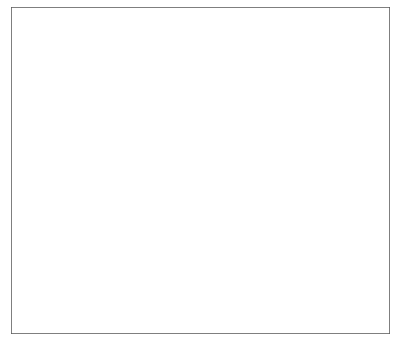

In [87]:
fig, ax = plt.subplots(figsize=(col_width3, 3*2))

ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks([])
    
figure2bis(fig, ax)
figure2bis(fig, ax, hoffset=0., df_plot=df25, d=df_sum25, ylim1=[-8,800], ylim2=[-500,400],
        year="(b) 2025", fig_name='fig2b',
        ytxt1=600, ytxt2=-300)

ax.axhline(0.5, color='k', lw=0.5)

plt.subplots_adjust(left=0.01, right=.99, top=.99, bottom=0.01)
plt.savefig('figures/fig2.pdf', dpi=300)
plt.savefig('figures/fig2.png', dpi=300)